Training Polynomial Kernel SVM...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Current fold accuracy: 0.29798356982823004
Current fold accuracy: 0.2815533980582524
Current fold accuracy: 0.35175504107542943
Current fold accuracy: 0.296711509715994
Current fold accuracy: 0.28325859491778776
Current fold accuracy: 0.3393124065769806
Current fold accuracy: 0.32486930545182974
Current fold accuracy: 0.2937219730941704
Current fold accuracy: 0.28133756771903606
[CV] END ..............C=0.1, coef0=0, degree=2, kernel=poly; total time=   0.7s
Current fold accuracy: 0.3340183074911265
[CV] END ..............C=0.1, coef0=0, degree=3, kernel=poly; total time=   0.6s
Current fold accuracy: 0.2987110031757893
[CV] END ..............C=0.1, coef0=0, degree=2, kernel=poly; total time=   0.7s
Current fold accuracy: 0.2969742248785954
[CV] END ..............C=0.1, coef0=0, degree=2, kernel=poly; total time=   0.7s
Current fold accuracy: 0.33526335450130745
[CV] END ..............C=0.1,

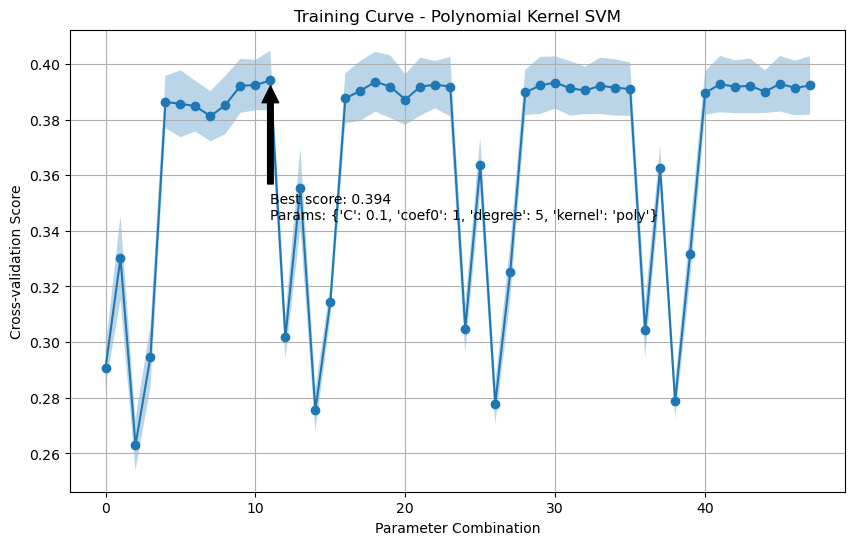

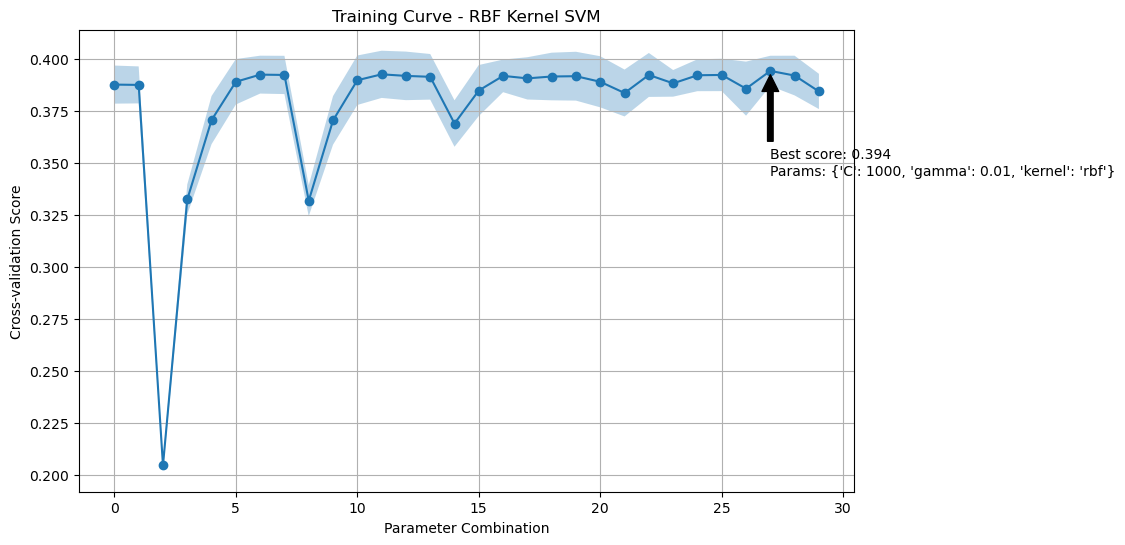


Polynomial Kernel SVM Results:
Best Parameters: {'C': 0.1, 'coef0': 1, 'degree': 5, 'kernel': 'poly'}
Best Cross-validation Score: 0.3940505095496606
Test Accuracy: 0.39860488290981566
              precision    recall  f1-score   support

         0.0       0.69      0.74      0.71       359
         1.0       0.95      0.90      0.92       264
         2.0       0.19      0.39      0.25       198
         3.0       0.18      0.33      0.24       166
         4.0       0.13      0.01      0.03       200
         5.0       0.14      0.01      0.01       160
         6.0       0.15      0.06      0.08       170
         7.0       0.29      0.49      0.36       147
         8.0       0.31      0.07      0.12       166
         9.0       0.24      0.38      0.30       177

    accuracy                           0.40      2007
   macro avg       0.33      0.34      0.30      2007
weighted avg       0.39      0.40      0.37      2007


RBF Kernel SVM Results:
Best Parameters: {'C': 1000, '

/opt/homebrew/Caskroom/miniforge/base/envs/data__env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/data__env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/data__env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [1]:
# --- Data Loading and Preprocessing ---
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, make_scorer
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Load the data from text files
train_data = np.loadtxt('Training.txt')
test_data = np.loadtxt('Test.txt')

# Separate features and labels
X_train = train_data[:, 1:]  # Features: intensity and symmetry
y_train = train_data[:, 0]   # Target: digit
X_test = test_data[:, 1:]    # Features: intensity and symmetry
y_test = test_data[:, 0]     # Target: digit

# Convert training data to a DataFrame for easier manipulation
df_train = pd.DataFrame(train_data, columns=["Digit", "Intensity", "Symmetry"])

# Separate majority and minority classes
df_0 = df_train[df_train.Digit == 0]
df_1 = df_train[df_train.Digit == 1]
df_minority = df_train[df_train.Digit > 1]

# Downsample majority classes
df_0_downsampled = resample(df_0, 
                            replace=False,    # sample without replacement
                            n_samples=800,    # match the number of samples in minority class
                            random_state=42)  # reproducible results

df_1_downsampled = resample(df_1, 
                            replace=False, 
                            n_samples=800, 
                            random_state=42)

# Combine minority class with downsampled majority classes
df_train_balanced = pd.concat([df_0_downsampled, df_1_downsampled, df_minority])

# Shuffle the dataset
df_train_balanced = df_train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and labels
X_train_balanced = df_train_balanced[["Intensity", "Symmetry"]].values
y_train_balanced = df_train_balanced["Digit"].values

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

def custom_score(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Current fold accuracy: {accuracy}")
    return accuracy

custom_scorer = make_scorer(custom_score)

def plot_training_curve(grid_result, title):
    mean_scores = grid_result.cv_results_['mean_test_score']
    std_scores = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    
    plt.figure(figsize=(10, 6))
    plt.title(f"Training Curve - {title}")
    plt.xlabel("Parameter Combination")
    plt.ylabel("Cross-validation Score")
    plt.plot(range(len(mean_scores)), mean_scores, 'o-')
    plt.fill_between(range(len(mean_scores)), mean_scores - std_scores, mean_scores + std_scores, alpha=0.3)
    plt.grid(True)
    
    # Annotate best score
    best_index = np.argmax(mean_scores)
    best_score = mean_scores[best_index]
    best_param = params[best_index]
    plt.annotate(f'Best score: {best_score:.3f}\nParams: {best_param}', 
                 xy=(best_index, best_score), xytext=(best_index, best_score-0.05),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.show()

# Set up the parameter grid for polynomial kernel
param_grid_poly = {
    'C': [0.1, 1, 10, 100],
    'degree': [2, 3, 4, 5],
    'coef0': [0, 0.5, 1],
    'kernel': ['poly']
}

# Set up the parameter grid for RBF kernel
param_grid_rbf = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

# Create a GridSearchCV object for both kernels with custom scorer and verbose output
svm_poly = GridSearchCV(SVC(), param_grid_poly, cv=5, scoring=custom_scorer, verbose=2, n_jobs=-1, return_train_score=True)
svm_rbf = GridSearchCV(SVC(), param_grid_rbf, cv=5, scoring=custom_scorer, verbose=2, n_jobs=-1, return_train_score=True)

# Train the SVM models using the balanced and scaled data
print("Training Polynomial Kernel SVM...")
svm_poly.fit(X_train_scaled, y_train_balanced)

print("\nTraining RBF Kernel SVM...")
svm_rbf.fit(X_train_scaled, y_train_balanced)

# Plot training curves
plot_training_curve(svm_poly, "Polynomial Kernel SVM")
plot_training_curve(svm_rbf, "RBF Kernel SVM")

# Predict and evaluate the polynomial kernel model
y_pred_poly = svm_poly.predict(X_test_scaled)
print("\nPolynomial Kernel SVM Results:")
print("Best Parameters:", svm_poly.best_params_)
print("Best Cross-validation Score:", svm_poly.best_score_)
print("Test Accuracy:", accuracy_score(y_test, y_pred_poly))
print(classification_report(y_test, y_pred_poly))

# Predict and evaluate the RBF kernel model
y_pred_rbf = svm_rbf.predict(X_test_scaled)
print("\nRBF Kernel SVM Results:")
print("Best Parameters:", svm_rbf.best_params_)
print("Best Cross-validation Score:", svm_rbf.best_score_)
print("Test Accuracy:", accuracy_score(y_test, y_pred_rbf))
print(classification_report(y_test, y_pred_rbf))


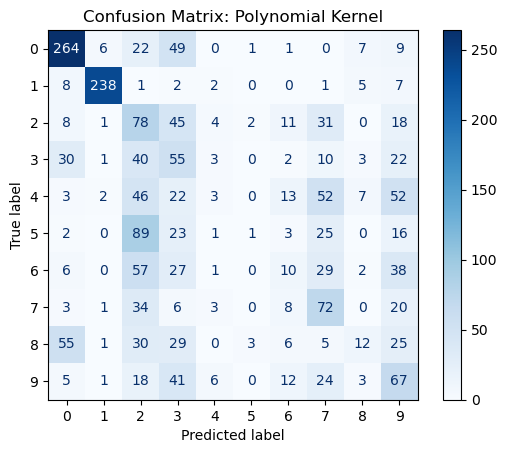

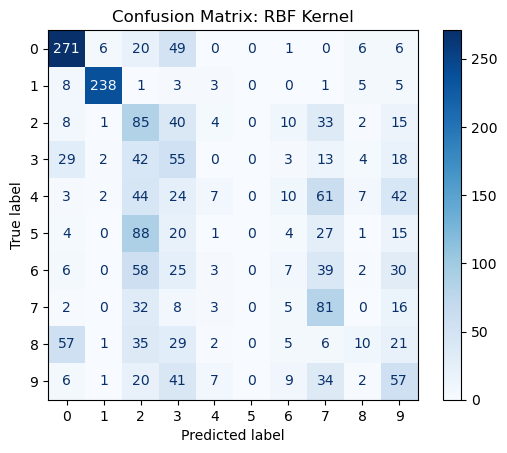

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix for Polynomial Kernel
cm_poly = confusion_matrix(y_test, y_pred_poly)
ConfusionMatrixDisplay(cm_poly, display_labels=range(10)).plot(cmap='Blues')
plt.title('Confusion Matrix: Polynomial Kernel')
plt.show()

# Confusion matrix for RBF Kernel
cm_rbf = confusion_matrix(y_test, y_pred_rbf)
ConfusionMatrixDisplay(cm_rbf, display_labels=range(10)).plot(cmap='Blues')
plt.title('Confusion Matrix: RBF Kernel')
plt.show()